In [1]:
import os
import time, datetime
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import time
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

### FUNCTIONS

In [2]:
def plot_win_percentage(df, col, label_col, target='won'):
    
    tmp1 = df[[col, target]].groupby([col, target]).size().reset_index(name='wins')
    tmp2 = pd.DataFrame({'win_pct' : tmp1.groupby([col])['wins'].apply(lambda x: round(x / x.sum(), 2))})
    tmp3 = pd.concat([tmp1, tmp2], axis=1)
    tmp3 = tmp3[tmp3[target] == 1]

    plt.figure(figsize=(8, 6), dpi=100)
    sns.lineplot(x=tmp3[col].astype(int), y=tmp3['win_pct'])
    plt.xlabel(label_col, fontsize=14)
    plt.ylabel('win percentage', fontsize=14)
    plt.title(f'{label_col} vs win percentage')
    #plt.savefig(os.path.join('OUTPUT_PATH', '{}_pct_win.png'.format(label_col)))
    plt.show()

### DATA

In [3]:
DATA_PATH = '../input/hkracing'

df_races = pd.read_csv(os.path.join(DATA_PATH, 'races.csv'))
df_runs = pd.read_csv(os.path.join(DATA_PATH, 'runs.csv'))

df_runners = pd.merge(df_races, df_runs, on='race_id', how='left')

### STATISTICS

In [4]:
print(f"Number of races : {df_runners.race_id.nunique()}")
print(f"Number of different horses : {df_runners.horse_id.nunique()}")
print(f"Number of different jockeys : {df_runners.jockey_id.nunique()}")
print(f"Number of different trainers : {df_runners.trainer_id.nunique()}")
print(f"Number of races' place : {df_runners.venue.nunique()}")
print(f"Data Period covered from {df_runners.date.min()} to {df_runners.date.max()}")
print(f"Number of different countries : {df_runners.horse_country.nunique()}")
print(f"Most dominant country : {df_runners.horse_country.mode()[0]}")
print(f"Most dominant horse type : {df_runners.horse_type.mode()[0]}")
print(f"Total high races run by a horse : {df_runners.horse_id.value_counts()[0]}")

Number of races : 6349
Number of different horses : 4405
Number of different jockeys : 186
Number of different trainers : 176
Number of races' place : 2
Data Period covered from 1997-06-02 to 2005-08-28
Number of different countries : 16
Most dominant country : AUS
Most dominant horse type : Gelding
Total high races run by a horse : 39


### MISSING VALUES

In [5]:
features_with_missing_values = df_runners.columns[df_runners.isna().sum(axis=0) > 0]
print(f"There is {len(features_with_missing_values)} features with missing values among the {df_runners.shape[1]} variables")

There is 51 features with missing values among the 73 variables


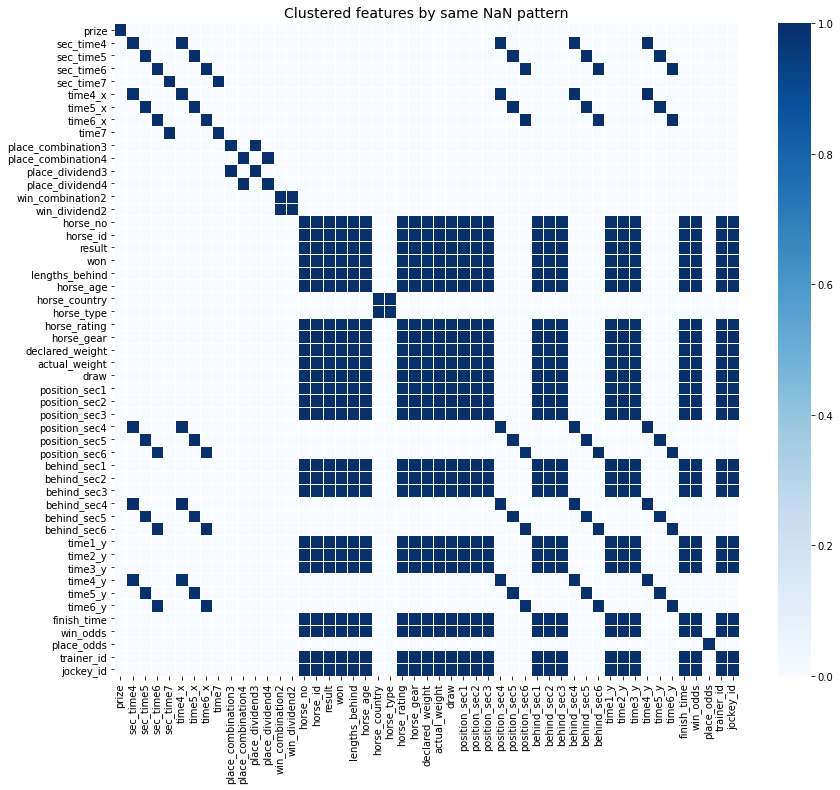

In [6]:
temp = df_runners[features_with_missing_values].isna()
temp = temp.astype(int).values

n = np.zeros((len(features_with_missing_values), len(features_with_missing_values)))
for i in (range(len(features_with_missing_values))):
    for j in range(len(features_with_missing_values)):
        n[i, j] = (temp[:, i]==temp[:, j]).all()

del temp

n  = pd.DataFrame(columns = features_with_missing_values, data=n, index= features_with_missing_values)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,12))
sns.heatmap(n, cmap='Blues', linewidths=.5,)
ax.set_title('Clustered features by same NaN pattern', fontsize=14)
plt.show()

- More than 90% of race date are missing 

### ADDITIONAL FEATURES

In [7]:
def is_place(result):
    return (result <= 3)*1

def compute_time_feats(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = (df['month'] + 2)//3
    
    return df

def compute_race_feats(df):  
    df['horse_under_4'] = df['horse_age'].apply(lambda a: 1 if a <= 4 else 0)
    df_runners_per_race = df[['race_id', 'horse_no']].groupby('race_id').size().reset_index(name='number_of_runners')
    df_runners_age = df[['race_id', 'horse_under_4']].groupby('race_id').sum().reset_index().rename(columns={'horse_under_4':'number_of_runners_under_4'})
    
    df = pd.merge(df, df_runners_per_race, on='race_id', how='left')
    df = pd.merge(df, df_runners_age, on='race_id', how='left')
    
    df['ratio_runners_under_4'] = df['number_of_runners_under_4'] / df['number_of_runners']
    del df_runners_per_race, df_runners_age
    
    return df


def compute_horse_feats(df, group_col='venue'):   
    df = df.sort_values('date')  
    df['place'] = list(map(is_place, df['result']))
    df['last_place'] =   list(map(is_place, df.groupby('horse_id')['result'].shift()))
    df['last_draw'] = df.groupby('horse_id')['draw'].shift()    
    df['horse_rest_time'] = (df['date'] - df.groupby('horse_id')['date'].shift()).dt.days
    df['horse_rest_lest14'] = (df['horse_rest_time'] <= 14)*1
    df['horse_rest_over35'] = (df['horse_rest_time'] >= 35)*1
    df['diff_declared_weight'] = df['declared_weight'] - df.groupby('horse_id')['declared_weight'].shift()
    df['diff_distance'] = df['distance'] - df.groupby('horse_id')['distance'].shift()
    
    df['horse_runs'] = df.sort_values('date').groupby(['horse_id']).cumcount()
    df['horse_wins'] = df.sort_values('date').groupby(['horse_id'])['won'].cumsum().sub(df.won)
    df['horse_places'] = df.sort_values('date').groupby(['horse_id'])['place'].cumsum().sub(df.place)
    
    try:
        df['ratio_win_horse'] = df['horse_wins'] / df['horse_runs']
        df['ratio_place_horse'] = df['horse_places'] / df['horse_runs']    
        
    except ZeroDivisionError:
        return 0
    
    if group_col:
        
        df[f'horse_{group_col}_runs'] = df.sort_values('date').groupby(['horse_id', group_col]).cumcount()
        df[f'horse_{group_col}_wins'] = df.sort_values('date').groupby(['horse_id', group_col])['won'].cumsum().sub(df.won)
        df[f'horse_{group_col}_places'] = df.sort_values('date').groupby(['horse_id', group_col])['place'].cumsum().sub(df.place)
        
        try:
            df[f'ratio_win_horse_{group_col}'] = df[f'horse_{group_col}_wins'] / df[f'horse_{group_col}_runs']
            df[f'ratio_place_horse_{group_col}'] = df[f'horse_{group_col}_places'] / df[f'horse_{group_col}_runs']
            
        except ZeroDivisionError:
            return 0 
   
    return df


def compute_owner_feats(df, owner=None, group_col='venue'):
  
    """ function to compute statistics of the jockey and the trainer """  

    df[f'{owner}_runs'] = df.sort_values('date').groupby(f'{owner}_id').cumcount()
    df[f'{owner}_wins'] = df.sort_values('date').groupby(f'{owner}_id')['won'].cumsum().sub(df.won)
    df[f'{owner}_places'] = df.sort_values('date').groupby(f'{owner}_id')['place'].cumsum().sub(df.place)
    
    try:
        df[f'ratio_win_{owner}'] = df[f'{owner}_wins'] / df[f'{owner}_runs']
        df[f'ratio_place_{owner}'] = df[f'{owner}_places'] / df[f'{owner}_runs']
        
    except ZeroDivisionError:
        return 0
    
    if group_col:
        
        df[f'{owner}_{group_col}_runs'] = df.sort_values('date').groupby([f'{owner}_id', group_col]).cumcount()
        df[f'{owner}_{group_col}_wins'] = df.sort_values('date').groupby([f'{owner}_id', group_col])['won'].cumsum().sub(df.won)
        df[f'{owner}_{group_col}_places'] = df.sort_values('date').groupby([f'{owner}_id', group_col])['place'].cumsum().sub(df.place)
        
        try:
            df[f'ratio_win_{owner}_{group_col}'] = df[f'{owner}_{group_col}_wins'] / df[f'{owner}_{group_col}_runs']
            df[f'ratio_place_{owner}_{group_col}'] = df[f'{owner}_{group_col}_places'] / df[f'{owner}_{group_col}_runs']
            
        except ZeroDivisionError:
            return 0    
        
    return df


def fillna(df, na_cols, na_value=0):
    for col in na_cols:
        df[col] = df[col].fillna(na_value)
    return df

df_runners = compute_time_feats(df_runners)
df_runners = compute_race_feats(df_runners)
df_runners = compute_horse_feats(df_runners, group_col='venue')
df_runners = compute_horse_feats(df_runners, group_col='surface')
df_runners = compute_horse_feats(df_runners, group_col='going')
df_runners = compute_horse_feats(df_runners, group_col='distance')
df_runners = compute_owner_feats(df_runners, owner='jockey')
df_runners = compute_owner_feats(df_runners, owner='trainer')

na_cols = df_runners.filter(regex="ratio|runs").columns.tolist()
df_runners = fillna(df_runners, na_cols)

### DATA DISTRIBUTION

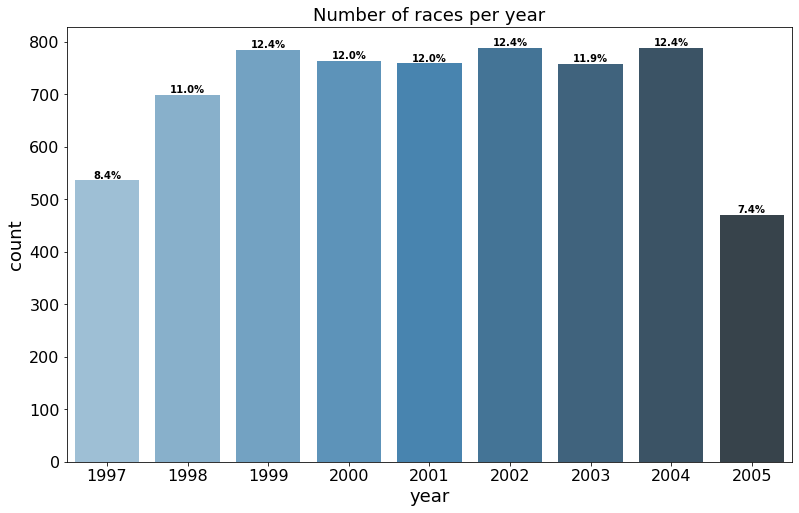

In [8]:
fig, ax = plt.subplots(figsize = (13, 8))
sns.countplot(x = df_runners.drop_duplicates(subset=['race_id', 'year'], keep='first')['year'], palette='Blues_d')

total = float(df_runners.race_id.nunique())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.1f}%'.format(100*height/total),
            ha="center", fontsize=10, fontweight='bold')
   
plt.title('Number of races per year', fontsize=18)
plt.xlabel('year', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.savefig('year_distribution.png')
plt.show()

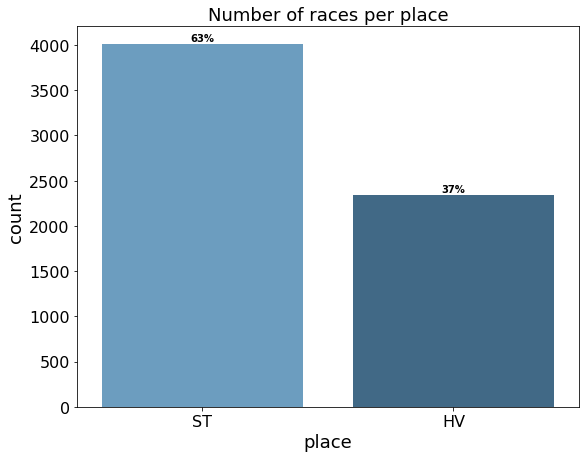

In [9]:
fig, ax = plt.subplots(figsize = (9, 7))
sns.countplot(x = df_runners.drop_duplicates(subset=['race_id', 'venue'], keep='first')['venue'], palette='Blues_d')

total = float(df_runners.race_id.nunique())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 35,
            '{:1.0f}%'.format(100*height/total),
            ha="center", fontsize=10, fontweight='bold')
   
plt.title('Number of races per place', fontsize=18)
plt.xlabel('place', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.savefig('hippo_distribution.png')
plt.show()

### TARGET DISTRIBUTION

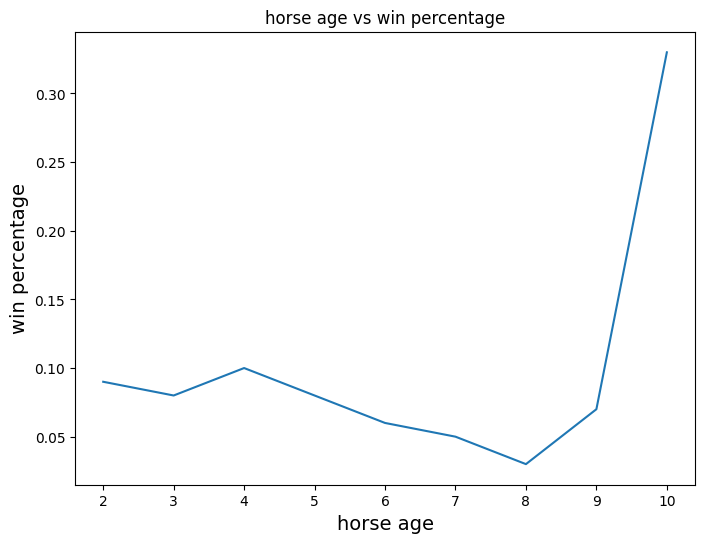

In [10]:
plot_win_percentage(df_runners, 'horse_age', 'horse age')

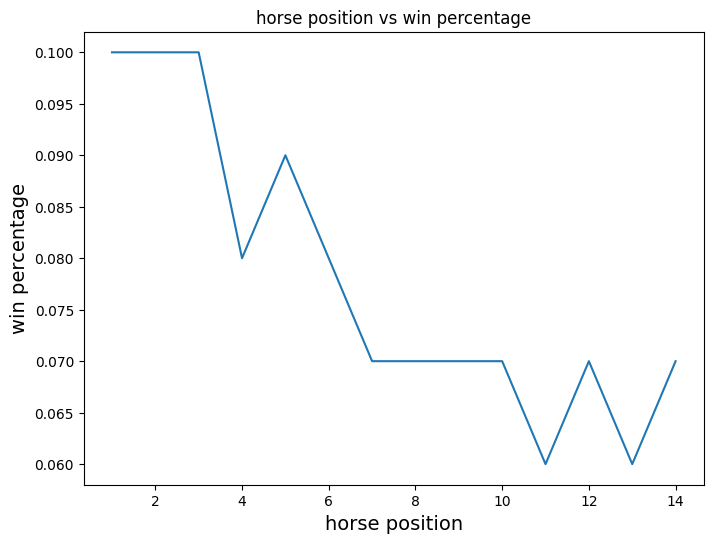

In [11]:
plot_win_percentage(df_runners, 'draw', 'horse position')

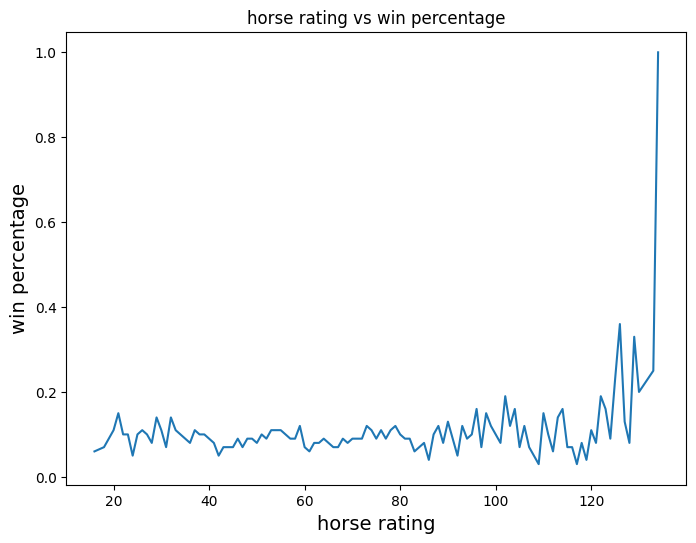

In [12]:
plot_win_percentage(df_runners, 'horse_rating', 'horse rating')

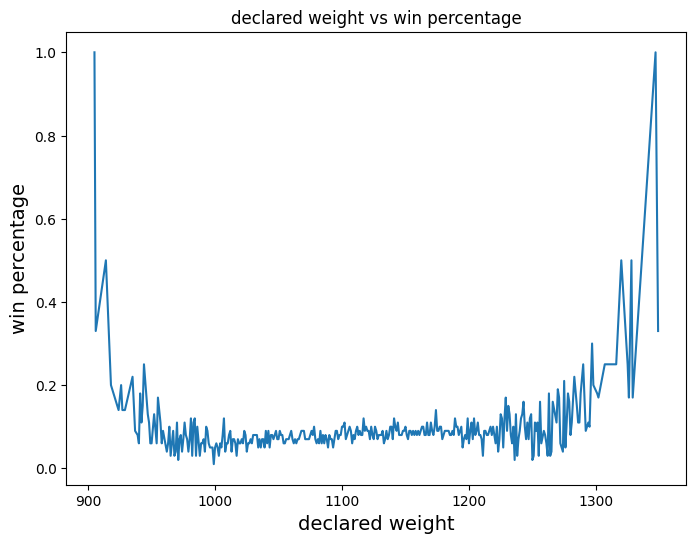

In [13]:
plot_win_percentage(df_runners, 'declared_weight', 'declared weight')

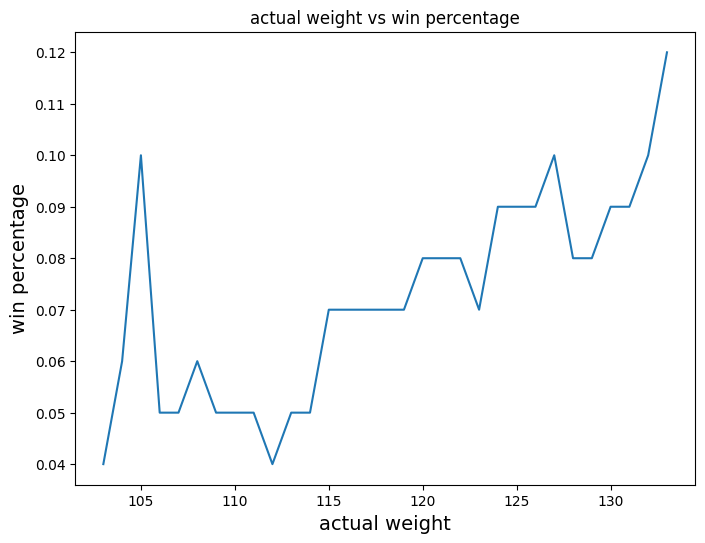

In [14]:
plot_win_percentage(df_runners, 'actual_weight', 'actual weight')

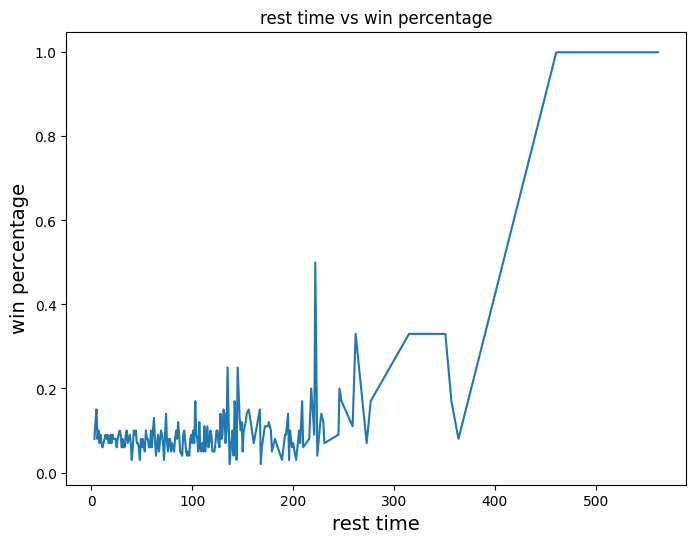

In [15]:
plot_win_percentage(df_runners, 'horse_rest_time', 'rest time')

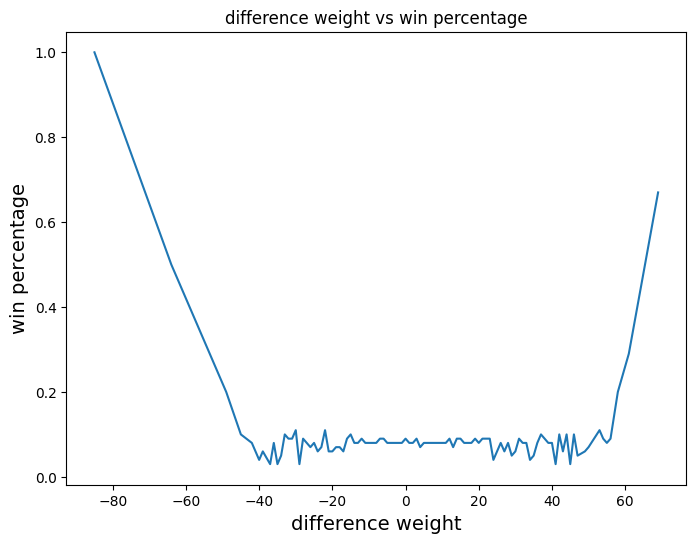

In [16]:
plot_win_percentage(df_runners, 'diff_declared_weight', 'difference weight')

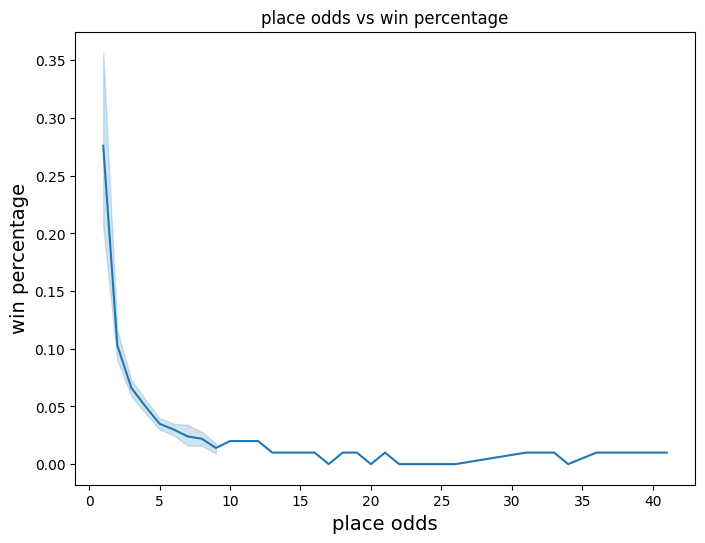

In [17]:
plot_win_percentage(df_runners, 'place_odds', 'place odds')

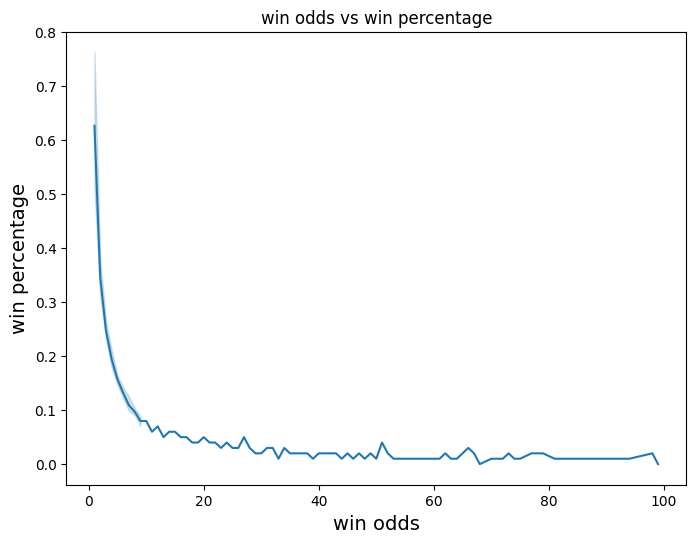

In [18]:
plot_win_percentage(df_runners, 'win_odds', 'win odds')

In [19]:
df_runners.columns

Index(['race_id', 'date', 'venue', 'race_no', 'config', 'surface', 'distance',
       'going', 'horse_ratings', 'prize',
       ...
       'trainer_runs', 'trainer_wins', 'trainer_places', 'ratio_win_trainer',
       'ratio_place_trainer', 'trainer_venue_runs', 'trainer_venue_wins',
       'trainer_venue_places', 'ratio_win_trainer_venue',
       'ratio_place_trainer_venue'],
      dtype='object', length=133)

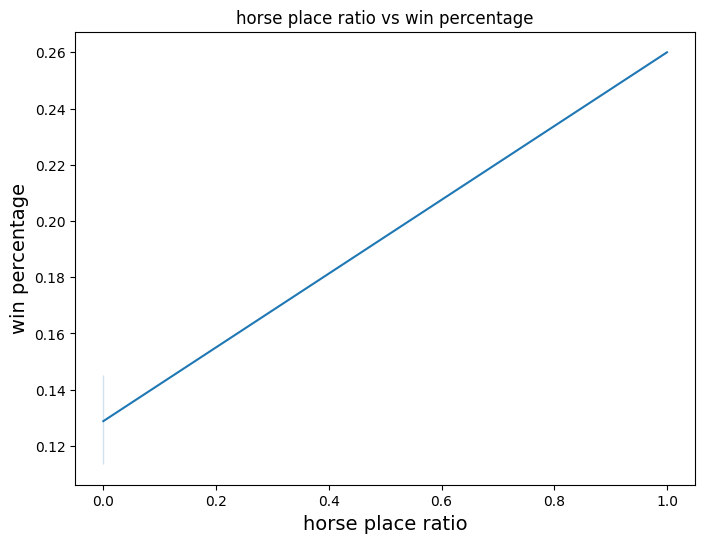

In [20]:
plot_win_percentage(df_runners, 'ratio_place_horse', 'horse place ratio')

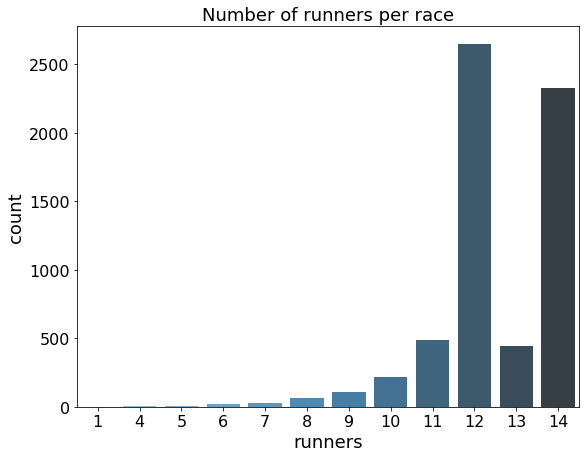

In [21]:
df_runners_per_race = df_runners[['race_id', 'horse_no']].groupby('race_id').size().reset_index(name='number_of_runners')

fig, ax = plt.subplots(figsize = (9, 7))
sns.countplot(x = df_runners_per_race['number_of_runners'], palette='Blues_d')
   
plt.title('Number of runners per race', fontsize=18)
plt.xlabel('runners', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.show()

In [22]:
df_runners['number_of_runners'].value_counts(normalize=True)

14    0.409702
12    0.399356
13    0.072488
11    0.067982
10    0.027188
9     0.012348
8     0.006545
7     0.002467
6     0.001510
5     0.000252
4     0.000151
1     0.000013
Name: number_of_runners, dtype: float64

### TRAINER

In [23]:
df_runners[['race_id', 'trainer_id']].groupby('trainer_id').size().reset_index(name='trainer_runs').describe()

,trainer_id,trainer_runs
count,176.000000,176.000000
mean,87.500000,451.403409
std,50.950957,1138.320890
min,0.000000,1.000000
25%,43.750000,1.000000
50%,87.500000,2.000000
75%,131.250000,5.250000
max,175.000000,4739.000000


- 75% of trainers participate in less than 5 races

### JOCKEY

In [24]:
df_runners[['race_id', 'jockey_id']].groupby('jockey_id').size().reset_index(name='jockey_runs').describe()

,jockey_id,jockey_runs
count,186.000000,186.000000
mean,92.500000,427.134409
std,53.837719,935.997135
min,0.000000,1.000000
25%,46.250000,2.000000
50%,92.500000,10.500000
75%,138.750000,240.250000
max,185.000000,4719.000000
